In [1]:
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F
import matplotlib.pylab as plt
import numpy as np
torch.manual_seed(2)

<h2 id="Model">Neural Network Module and Training Function</h2> 


<img src="https://ibm.box.com/shared/static/5wtclahun0f70qlwkn2kxzh3amnbq4zg.png" width="200" alt="Neural Network Model">


In [2]:
# Using relu activation function
class NetRelu(nn.Module):
    
    # Constructor
    def __init__(self, D_in, H1, H2, D_out):
        '''
        D_in = Total dimenstiom in the input layer
        H1 = Total neurons in the first hidden layer
        H2 = Total neurons in the second hidden layer
        D_out = Total output from from model
        '''
        super(NetRelu, self).__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1,H2)
        self.linear3 = nn.Linear(H2, D_out)
        
    # Predictions
    def forward(self, x):
        x = torch.relu(self.linear1(x)) # Hidden layer 1
        x = torch.relu(self.linear2(x)) # Hidden layer 2
        x = self.linear3(x) # Output layer
        return x

In [3]:
# Train the model

def train(model, criterion, train_loader, validation_loader, optimizer, epochs=100):
    i = 0
    useful_stuff = {'training_loss': [], 'validation_accuracy': []}  
    
    for epoch in range(epochs):
        for i, (x, y) in enumerate(train_loader):
            optimizer.zero_grad()
            z = model(x.view(-1, 28 * 28))
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            useful_stuff['training_loss'].append(loss.data.item())
        
        correct = 0
        for x, y in validation_loader:
            z = model(x.view(-1, 28 * 28))
            _, label = torch.max(z, 1)
            correct += (label == y).sum().item()
    
        accuracy = 100 * (correct / len(validation_dataset))
        useful_stuff['validation_accuracy'].append(accuracy)
    
    return useful_stuff

In [4]:
# Make some data
train_dataset = dsets.MNIST(root = './data', train = True, download = True, transform = transforms.ToTensor())

# Create the validating dataset
validation_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())


# Create the training data loader and validation data loader object
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=2000, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000, shuffle=False)

In [5]:
# Define the model parameters
criterion = nn.CrossEntropyLoss()

# Set the parameters for create the model
input_dim = 28*28
hidden_dim1 = 50
hidden_dim2 = 50
output_dim = 10

# Set the epoch numbers
cust_epochs = 50

learning_rate = 0.01

In [6]:
# Train the model

modelRelu = NetRelu(input_dim, hidden_dim1, hidden_dim2, output_dim)
optimizer = torch.optim.SGD(modelRelu.parameters(), lr = learning_rate)
training_results_relu = train(modelRelu, criterion, train_loader, validation_loader, optimizer, epochs = cust_epochs)

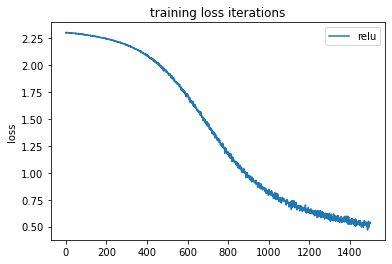

In [7]:
# Compare the training loss

plt.plot(training_results_relu['training_loss'], label='relu')
plt.ylabel('loss')
plt.title('training loss iterations')
plt.legend()

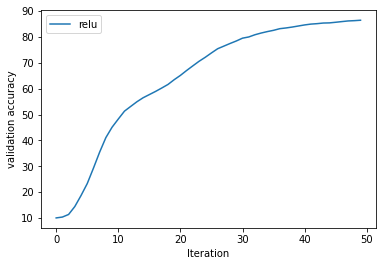

In [8]:
plt.plot(training_results_relu['validation_accuracy'], label = 'relu') 
plt.ylabel('validation accuracy')
plt.xlabel('Iteration')   
plt.legend()